## Importing Libraries & Setting up Spark

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import findspark
findspark.init()

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier

In [2]:
#Function to Appy String Indexer for categorical values: 
def Indexe(lsds, col_name):
    opcol = col_name.upper()
    lsds = StringIndexer(inputCol= col_name, outputCol=opcol, handleInvalid='keep').fit(lsds).transform(lsds)
    return lsds

#Function to get input values and store it into a Spark Dataframe
def GetVal(header):
    
    print("Enter Values For User Test Data:")
    cand = input("Enter Candidate Name :")
    party = input("Enter Party:")
    cc = input("Enter criminal cases :")
    edu = input("Enter education :")
    age = input("Enter age :")
    asset = input("Enter asset:")
    cstcy = input("Enter constituency:")
    liab = input("Enter liabilities :")
    gender = input("Enter Gender :")
    
    test = {header[0]: cand, header[1]:party , header[2]:cc,header[3]:edu,header[4]:age,header[5]:asset,header[6]:cstcy,header[7]:liab,header[8]:gender}
    print(test)
    dt = pd.DataFrame(test,index = [0])
    dt.reset_index(inplace=True)
    sparkdt = spark.createDataFrame(dt)
    return sparkdt



## Fetching the Datasets

In [3]:
spark = SparkSession.builder.master("local").appName("Politicians").enableHiveSupport().getOrCreate()

22/11/10 14:25:03 WARN Utils: Your hostname, theeraj-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
22/11/10 14:25:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/10 14:25:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark.sql("show tables").show()

22/11/10 14:25:11 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
22/11/10 14:25:11 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
22/11/10 14:25:13 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|  default|   ls2004|      false|
|  default|   ls2009|      false|
|  default|   ls2014|      false|
|  default|   ls2019|      false|
+---------+---------+-----------+



In [5]:
ls2004 = spark.sql("Select * from ls2004")
ls2009 = spark.sql("Select * from ls2009")
ls2014 = spark.sql("Select * from ls2014")
ls2019 = spark.sql("Select * from ls2019")

ls2004.show(5)

22/11/10 14:25:16 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
+-----------------+-----+--------------+-------------+----+------------+--------------------+-----------+------+------+
|        candidate|party|criminal_cases|    education| age|total_assets|        constituency|liabilities|winner|gender|
+-----------------+-----+--------------+-------------+----+------------+--------------------+-----------+------+------+
|        Candidate|Party|          null|    Education|null|        null|        Constituency|       null|  null|Gender|
|Manoranjan Bhakta|  INC|             0|Post Graduate|  65|     5926740|Andaman & Nicobar...|     272061|     1|     M|
|       A K Biswas|  BSP|             0|     Graduate|  61|     7876500|Andaman & Nicobar...|      65000|     0|     M|
| Asit Baran Dutta|  IND|             0|     Graduate|  50|     3070000|Andaman & Nicobar...|          0|     0|     

# Preprocessing the Dataset

Removing null values

In [6]:
ls2004 = ls2004.na.drop()
ls2009 = ls2009.na.drop()
ls2014 = ls2014.na.drop()
ls2019 = ls2019.na.drop()

Viewing changes

In [7]:
ls2004.show(5)
ls2009.show(5)

+-----------------+-----+--------------+-------------+---+------------+--------------------+-----------+------+------+
|        candidate|party|criminal_cases|    education|age|total_assets|        constituency|liabilities|winner|gender|
+-----------------+-----+--------------+-------------+---+------------+--------------------+-----------+------+------+
|Manoranjan Bhakta|  INC|             0|Post Graduate| 65|     5926740|Andaman & Nicobar...|     272061|     1|     M|
|       A K Biswas|  BSP|             0|     Graduate| 61|     7876500|Andaman & Nicobar...|      65000|     0|     M|
| Asit Baran Dutta|  IND|             0|     Graduate| 50|     3070000|Andaman & Nicobar...|          0|     0|     M|
|  Bishnu Pada Ray|  BJP|             0|     Graduate| 54|     1250619|Andaman & Nicobar...|     128710|     0|     M|
|    Deepak Biswas|  IND|             0|    Not Given| 28|        3000|Andaman & Nicobar...|          0|     0|     M|
+-----------------+-----+--------------+--------

In [8]:
ls2004.toPandas()

22/11/10 14:25:18 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


,candidate,party,criminal_cases,education,age,total_assets,constituency,liabilities,winner,gender
0,Manoranjan Bhakta,INC,0,Post Graduate,65,5926740,Andaman & Nicobar Islands,272061,1,M
1,A K Biswas,BSP,0,Graduate,61,7876500,Andaman & Nicobar Islands,65000,0,M
2,Asit Baran Dutta,IND,0,Graduate,50,3070000,Andaman & Nicobar Islands,0,0,M
3,Bishnu Pada Ray,BJP,0,Graduate,54,1250619,Andaman & Nicobar Islands,128710,0,M
4,Deepak Biswas,IND,0,Not Given,28,3000,Andaman & Nicobar Islands,0,0,M
...,...,...,...,...,...,...,...,...,...,...
3349,Snehanshu Maity,IND,0,Not Given,35,12463,Uluberia,0,0,M
3350,Susmita Bauri,CPM,0,Graduate Professional,29,33000,Vishnupur,10000,1,F
3351,Achintya Majhi,INC,0,Graduate,38,67264,Vishnupur,50050,0,M
3352,Ajoy Bauri,BSP,0,Not Given,40,35000,Vishnupur,0,0,M


# Feature Selection :

22/11/10 14:25:18 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


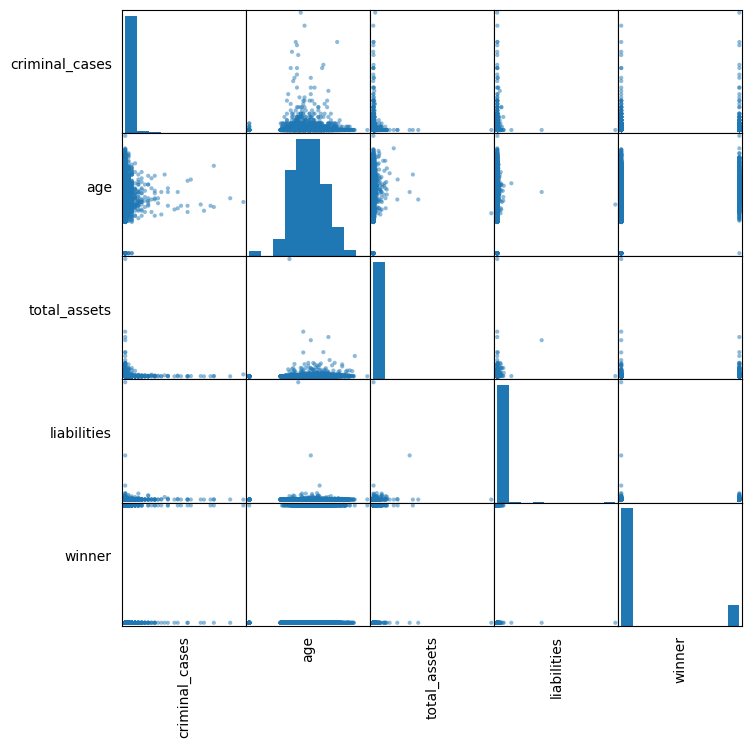

In [9]:
#Choose the features that affect the victory of candidate the most : pdls2004 = ls2004.toPandas( X = pdls2004.copy() Y = pdls2004.pop("winner")
numeric_features = [t[0] for t in ls2004.dtypes if t[1] == 'int']

numeric_data = ls2004.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

# Feature Engineering :

In [10]:
#Combining the datasets to form 1 big dataset ->
lsdata = ls2004.unionByName(ls2009)
lsdata = lsdata.unionByName(ls2014)
lsdata = lsdata.unionByName(ls2019)
lsdata.show(20)

+--------------------+----------+--------------+--------------------+---+------------+--------------------+-----------+------+------+
|           candidate|     party|criminal_cases|           education|age|total_assets|        constituency|liabilities|winner|gender|
+--------------------+----------+--------------+--------------------+---+------------+--------------------+-----------+------+------+
|   Manoranjan Bhakta|       INC|             0|       Post Graduate| 65|     5926740|Andaman & Nicobar...|     272061|     1|     M|
|          A K Biswas|       BSP|             0|            Graduate| 61|     7876500|Andaman & Nicobar...|      65000|     0|     M|
|    Asit Baran Dutta|       IND|             0|            Graduate| 50|     3070000|Andaman & Nicobar...|          0|     0|     M|
|     Bishnu Pada Ray|       BJP|             0|            Graduate| 54|     1250619|Andaman & Nicobar...|     128710|     0|     M|
|       Deepak Biswas|       IND|             0|           Not

In [11]:
#Using String Indexer to Index Features ->
lsdata_copy = lsdata

lsdata_copy = Indexe(lsdata_copy,'gender')
lsdata_copy = Indexe(lsdata_copy,'education')
lsdata_copy = Indexe(lsdata_copy,'party')

22/11/10 14:25:21 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


22/11/10 14:25:22 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:22 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:22 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


22/11/10 14:25:23 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:23 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:23 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:23 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:24 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:24 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:24 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:24 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


In [12]:
#Assembling the chosen features into a vector assembler ->
required_features = ['criminal_cases','EDUCATION','age','liabilities','GENDER']
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(lsdata_copy)

transformed_data.show(5)

+-----------------+-----+--------------+---------+---+------------+--------------------+-----------+------+------+--------------------+
|        candidate|PARTY|criminal_cases|EDUCATION|age|total_assets|        constituency|liabilities|winner|GENDER|            features|
+-----------------+-----+--------------+---------+---+------------+--------------------+-----------+------+------+--------------------+
|Manoranjan Bhakta|  1.0|             0|      1.0| 65|     5926740|Andaman & Nicobar...|     272061|     1|   0.0|[0.0,1.0,65.0,272...|
|       A K Biswas|  2.0|             0|      0.0| 61|     7876500|Andaman & Nicobar...|      65000|     0|   0.0|(5,[2,3],[61.0,65...|
| Asit Baran Dutta|  0.0|             0|      0.0| 50|     3070000|Andaman & Nicobar...|          0|     0|   0.0|      (5,[2],[50.0])|
|  Bishnu Pada Ray|  3.0|             0|      0.0| 54|     1250619|Andaman & Nicobar...|     128710|     0|   0.0|(5,[2,3],[54.0,12...|
|    Deepak Biswas|  0.0|             0|      8.

# Implementing ML models

In [13]:
#Models to implement : Logistic Regression, Random Forest Classifier & Gradient Boosted Tree 

Logistic Regression :

In [14]:
(train,test) = transformed_data.randomSplit([0.8,0.2])

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'winner', maxIter=10)
lrModel = lr.fit(train)

22/11/10 14:25:26 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


22/11/10 14:25:26 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:26 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:27 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


22/11/10 14:25:28 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:28 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:28 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


22/11/10 14:25:28 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


In [15]:
lrpredictions = lrModel.transform(test)

Gradient Boosted Tree:

In [16]:
(train1,test1) = transformed_data.randomSplit([0.8,0.2])

In [17]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'features',labelCol = 'winner',maxIter=10)
gbtModel = gbt.fit(train1)
gbtpredictions = gbtModel.transform(test1)

22/11/10 14:25:31 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:32 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:32 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:32 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:32 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


22/11/10 14:25:32 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:32 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:32 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:33 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:33 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:33 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:33 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:33 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


Random Forest Classifier : 

In [18]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])
rf = RandomForestClassifier(labelCol='winner', featuresCol='features',maxDepth=5)

In [19]:
model = rf.fit(training_data)

22/11/10 14:25:42 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:42 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:42 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:42 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:42 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:42 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:42 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:43 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:43 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:43 WARN LazyStruct: Extra bytes

In [20]:
rfcpredictions = model.transform(test_data)

# Accuracy 

Logistic Regression : 

22/11/10 14:25:46 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:46 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:46 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


22/11/10 14:25:47 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.


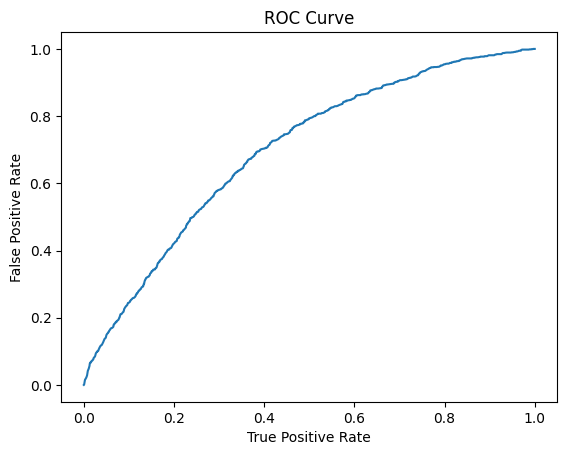

Training set areaUnderROC: 0.6969817400492601


In [21]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [22]:
lr_score = trainingSummary.areaUnderROC*100
print('Test Accuracy = ',lr_score,"%")

Test Accuracy =  69.698174004926 %


Gradient Boosted Tree :

In [23]:
#Plot the accuracy scores for both classifiers 
evaluator = MulticlassClassificationEvaluator(
    labelCol='winner', 
    predictionCol='prediction', 
    metricName='accuracy')

In [24]:
accuracy = evaluator.evaluate(gbtpredictions)
gbt_score =  accuracy*100
print('Test Accuracy = ',gbt_score,"%")

22/11/10 14:25:48 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:48 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:48 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:48 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
Test Accuracy =  93.52703199705775 %


Random Forest Classifier:

In [25]:
accuracy = evaluator.evaluate(rfcpredictions)
rfc_score =  accuracy*100
print('Test Accuracy = ',rfc_score,"%")

22/11/10 14:25:49 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:49 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:49 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
22/11/10 14:25:49 WARN LazyStruct: Extra bytes detected at the end of the row! Ignoring similar problems.
Test Accuracy =  93.75830013280213 %


# Inference

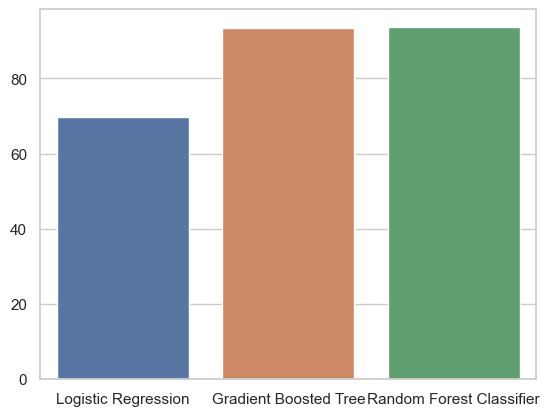

In [26]:
sns.set_theme(style='whitegrid')
mean_test_scores = pd.DataFrame(data=[[lr_score,
                                        gbt_score,rfc_score]],
                                 columns=['Logistic Regression', 'Gradient Boosted Tree','Random Forest Classifier'])
sns.barplot(data=mean_test_scores);